## Speck Simulation

In [1]:
import matplotlib.pyplot as pyplot
import numpy as np
from scipy.stats import pearsonr
import random
from operator import xor

# Fast implementation of the Hamming weight for 64 bit values
# See book: A Hacker's delight
# not sure if the hamming weight model w0rks for Speck
def popcount(x):
    x -= (x >> 1) & 0x5555555555555555
    x = (x & 0x3333333333333333) + ((x >> 2) & 0x3333333333333333)
    x = (x + (x >> 4)) & 0x0f0f0f0f0f0f0f0f
    return ((x * 0x0101010101010101) & 0xffffffffffffffff ) >> 56


In [2]:
import math

NUM_ROUNDS = 22
BLOCK_SIZE = 32
KEY_SIZE = 64
WORD_SIZE = 16


# SHIFTs for SPECK
ALPHA = 7
BETA = 2

mod_mask = (2 ** WORD_SIZE) -1
mod_mask_sub = (2 ** WORD_SIZE)

## Speck Implementation

First of all, a very simplified Speck implementation to support Speck 23/64 with 22 rounds and ALPHA = 7 and BETA = 3

1) Key = bytesToWords16(key)

2) scheduled_key = key_schedule(Key)

3) ciphertext = encrypt(plaintext, scheduled_key)


-> The encrypt funktion is currently `missing` ... only `simple_speck()`

In [13]:
'''
 Converts a bytestring `0xdeadbeef` to a array of 16-byte integers (len: 4)
'''
def bytesToWords16(b):       
    return [(b >> (x * WORD_SIZE)) & mod_mask for x in
                      range(0, math.ceil(KEY_SIZE // WORD_SIZE))]
        

In [14]:
[hex(x) for x in bytesToWords16(0x0102030405060708)]

['0x708', '0x506', '0x304', '0x102']

In [9]:
'''
 The 16bit Speck roundfunction, this is where the magic happens
'''
def ER16(x, y, k):

    rs_x = ((x << (16 - ALPHA)) + (x >> ALPHA)) & mod_mask

    add_sxy = (rs_x + y) & mod_mask

    new_x = k ^ add_sxy

    ls_y = ((y >> (16 - BETA)) + (y << BETA)) & mod_mask

    new_y = new_x ^ ls_y

    return new_x, new_y


## Running the key schedule

In [15]:
key = 0x0102030405060708

In [16]:
Key = bytesToWords16(key)

In [17]:
print([hex(x) for x in Key])

['0x708', '0x506', '0x304', '0x102']


In [18]:
'''

The 16 bit python key schedule

void Speck128256KeySchedule(u64 K[],u64 rk[])
{
    u64 i,D=K[3],C=K[2],B=K[1],A=K[0];
    for(i=0;i<33;){
        rk[i]=A; ER64(B,A,i++);
        rk[i]=A; ER64(C,A,i++);
        rk[i]=A; ER64(D,A,i++);
    }
    rk[i]=A;
}
'''
def key_schedule(k):

    D=k[3]
    C=k[2]
    B=k[1]
    A=k[0]
    out = []
    i = 0
    while i < 21:
        out.append(A)
        B, A = ER16(B, A, i)
        i += 1
        out.append(A)
        C, A = ER16(C, A, i)
        i+= 1
        out.append(A)
        D, A = ER16(D, A, i)
        i+= 1
    out.append(A)
    return out
        

In [39]:
'''
Simple encryption for speck (only the encryption part, without key scheduling)

void Speck128256Encrypt(u64 Pt[],u64 Ct[],u64 rk[])
{
    u64 i;
    Ct[0]=Pt[0]; Ct[1]=Pt[1];
    for(i=0;i<34;) ER64(Ct[1],Ct[0],rk[i++]);
}


'''
def simple_speck(plaintext, key):
    Ct_0 = plaintext[0]
    Ct_1 = plaintext[1]
    
    
    Ct_1, Ct_0 = ER16(Ct_1, Ct_0, key)   # fixed 16 bit key of 0x55
    return (Ct_1 << 8) + Ct_0

## Running tests to verify the output is still fine

In [22]:
assert key_schedule(Key) == [0x708,0xf32, 0x2bf1,0x8035,0xa48e,0x8482, 0x74ee, 0xf589, 0xb396, 0xb231, 0xdab2, 0x57bc, 0x704e,0x9947,0xe2d2, 0xea6a, 0x4ebe, 0xdd24, 0x6b64, 0x3ab1, 0x1c57, 0x7bde]

In [11]:
ciphertext = simple_speck([0xdead, 0xbeef], 0x55)

In [12]:
# over simplified Speck encryption (no key schedule)
print(hex(ciphertext))

0xbe7fc4c8


# Simulation

The following code simulates the Speck encryption process for an randomly choosen plaintext and the choosen key: **0x69**.

It correlates 1000 encryptions for random plaintext and correlates them for execution with every possible keybyte

8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
+++++++++++++++++++++++++++++++++++++++++++
8000
8000
++++++++++++++++++

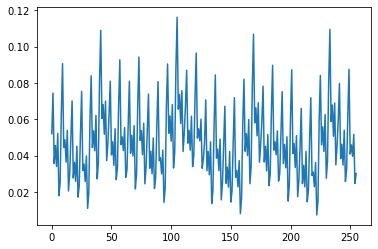

Correct 8-bit key is: 0x69


In [74]:
import random
num_traces = 8000

key_space = 256


traces = np.empty(num_traces)
hw_traces = np.empty((key_space, num_traces))

for i in range(0,num_traces):
    #plaintext = [(i**2) % 0xFFFF, i % 0xFFFF]
    plaintext = bytes([random.randint(0, 255) for i in range(4)])
    traces[i] = popcount(simple_speck(plaintext, 0x69)) + np.random.normal(1, 20, 1) # + noice (seems to need an higher trace-count)
    
    # this is the simulation of the estimated values, using the popcount
    for key in range(0, key_space):
        hw_traces[key][i] = popcount(simple_speck(plaintext, key))

corr = np.empty(key_space)

#compute pearson correlation for each key
for key in range(0, key_space):
    print(len(hw_traces[key]))  # estimates
    print(len(traces))          # 'captured' traces
    print("+++++++++++++++++++++++++++++++++++++++++++")
    corr[key],p = pearsonr(hw_traces[key], traces)

pyplot.plot(corr)
pyplot.show()

print("Correct 8-bit key is: " + hex(np.argmax(corr)))


### $\rightarrow$ Dafuq, at least something seems to w0rk

## 16-bit key

Breaking byte-by-byte for a 16-bit key (to not require the full $2^{16}$ keyspace)

In [52]:
def get_key(current_keybyte):
    num_traces = 5000

    key_space = 256


    traces = np.empty(num_traces)
    hw_traces = np.empty((key_space, num_traces))

    for i in range(0,num_traces):
        plaintext = [(i**2) % 0xFFFF, i % 0xFFFF]
        traces[i] = popcount(simple_speck(plaintext, 0xc0fe)) + np.random.normal(1, 20, 1) # + noice (seems to need an higher trace-count)
        for key in range(0, key_space):
            if current_keybyte == None:
                key_guess = key
            else:
                key_guess = (key << 8) + current_keybyte
            hw_traces[key][i] = popcount(simple_speck(plaintext, key_guess))

    corr = np.empty(key_space)

    #compute pearson correlation for each key
    for key in range(0, key_space):
        corr[key],p = pearsonr(hw_traces[key], traces)

    #pyplot.plot(corr)
    #pyplot.show()

    print("Correct 8-bit key is: " + hex(np.argmax(corr)))
    return np.argmax(corr)

In [55]:
def get_full_key():
    int_key = None
    full = []
    for i in range(WORD_SIZE // 8):
        int_key = int(get_key(int_key))
        full.append(int_key)
    return (full[1] << 8) + full[0]

In [56]:
print(f"Full 16-bit Key: {hex(get_full_key())}")

Correct 8-bit key is: 0xfe
Correct 8-bit key is: 0xc0
Full 16-bit Key: 0xc0fe
